In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib.patches as patches
from collections import defaultdict

In [3]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.nb_states = 7
        self.nb_actions = 2
        self.act_space = [0, 1]  # LEFT = 0, RIGHT = 1
        self.reset()

    def reset(self):
        self._state = np.random.randint(1, 5+1)
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1
        if action == 1: self._state += 1
            
        reward = -1
        if self._state < 1: self._done = True
        if self._state > 5: self._done = True
                
        return self._state, reward, self._done, None  # obs, rew, done, debug

In [50]:
class BanditEnv:
    def __init__(self, offset=0.0, variance=1.0):
        """10-armed testbed, see chapter 2.3"""
        self.nb_states = 1
        self.nb_actions = 10    # 10 arms
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,   # eyeball fig 2.1
                               -1.5, -0.25, -1, 0.75, -0.5]) * variance + offset
        # self.means = np.random.randn(10) * variance + offset
    
    def reset(self):
        return 0  # observation
        
    def step(self, action):
        # observation, reward, done, extra
        return 0, np.random.normal(loc=self.means[action]), True, None

In [5]:
class CorridorSwitchedEnv:
    """Short corridor with switched actions. See example 13.1 in the book.
    
    Note: Small change introduced to terminate after time step 1000
          to prevent infinite loop if policy becomes deterministic.
    """
    def __init__(self):
        self.nb_states = 1
        self.nb_actions = 2
        self._state = 0
        self._curr_iter = 0
        
    def reset(self):
        self._state = 0
        self._curr_iter = 0
        return 0    # states are indistinguisable
    
    def step(self, action):
        assert action in [0, 1]    # left, right
        
        if self._state == 0:
            if action == 1:
                self._state = 1
        elif self._state == 1:
            if action == 0:        # left, swapped to right
                self._state = 2
            else:                  # right, swapped to left
                self._state = 0
        elif self._state == 2:
            if action == 0:
                self._state = 1
            else:
                self._state = 3    # terminal
        else:
            raise ValueError('Invalid state:', self._state)
        
        # Terminate at time step = 1000
        self._curr_iter += 1
        if self._curr_iter >= 1000:
            self._state = 3
        
        if self._state == 3:
            return 0, -1, True, None    # obs, reward, done, extra
        else:
            return 0, -1, False, None

In [6]:
def softmax(x):
    """Numerically stable softmax"""
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

In [7]:
class TabularStateValueFunction:
    """Tabular state-value function 'approximator'"""
    def __init__(self, lr, nb_states):
        self._lr = lr
        self._w = np.zeros(nb_states)
    
    def evaluate(self, state):
        # or onehot(state, nb_states) @ self._w
        return self._w[state]
    
    def train(self, state, target):
        value = self.evaluate(state)
        self._w[state] += self._lr * (target - value)

In [8]:
class TabularSoftmaxPolicy:
    """Tabular action-state function 'approximator'"""
    def __init__(self, lr, nb_states, nb_actions, init_theta=None):
        self._lr = lr                                   # learning rate
        self.n_act = nb_actions
        self._theta = np.zeros((nb_states, nb_actions))  # weights
        if init_theta is not None:
            assert init_theta.dtype == np.float64
            assert init_theta.shape == self._theta.shape
            self._theta = init_theta
    
    def pi(self, state):
        """Return policy, i.e. probability distribution over actions."""
        h_vec = self._theta[state]
        prob_vec = softmax(h_vec)                     # shape=[n_act], e.q. 13.2
        assert prob_vec[0] != 0.0 and prob_vec[0] != 1.0
        assert prob_vec[1] != 0.0 and prob_vec[1] != 1.0
        return prob_vec


    def update(self, state, action, disc_return):
        x_s = np.zeros(self.n_act)
        x_s[action] = 1             # feature vector, one-hot
        prob = self.pi(state)
        grad_s = x_s - prob
        self._theta[state] += self._lr * disc_return * grad_s

In [9]:
def one_step_actor_critic(env, ep, gamma, alpha_w, alpha_theta, init_theta=None):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha_w (float): learning rate for state-value function
        alpha_theta (float): learning rate for policy
        init_theta (np.array): initialize policy weights, default np.zeros()
    """
    def policy(st, pi):
        return np.random.choice(range(env.nb_actions), p=pi.pi(st))
    
    hist_R = []
    hist_val = []
    hist_prob = []
    
    v_hat = TabularStateValueFunction(lr=alpha_w, nb_states=env.nb_states)
    pi = TabularSoftmaxPolicy(lr=alpha_theta,
                              nb_states=env.nb_states,
                              nb_actions=env.nb_actions,
                              init_theta=init_theta)
    
    for _ in range(ep):
        S = env.reset()
        I = 1
        
        R_sum = 0
        while True:
            A = policy(S, pi)
            S_, R, done, _ = env.step(A)
            
            target = R + gamma*v_hat.evaluate(S_) if not done else R
            delta = target - v_hat.evaluate(S)
            
            v_hat.train(S, target)
            pi.update(S, A, I*delta)
            
            I *= gamma
            S = S_
            
            R_sum += R
            if done: break
        
        hist_R.append(R_sum)
        hist_val.append([v_hat.evaluate(s) for s in range(env.nb_states)])
        hist_prob.append([pi.pi(s) for s in range(env.nb_states)])
    
    hist_R = np.array(hist_R)
    hist_val = np.array(hist_val)
    hist_prob = np.array(hist_prob)
    
    return hist_R, hist_val, hist_prob

In [18]:
env = LinearEnv()

In [19]:
hist_R, hist_val, hist_prob = one_step_actor_critic(env, ep=1000, gamma=1.0, alpha_w=2**-4, alpha_theta=2**-2)

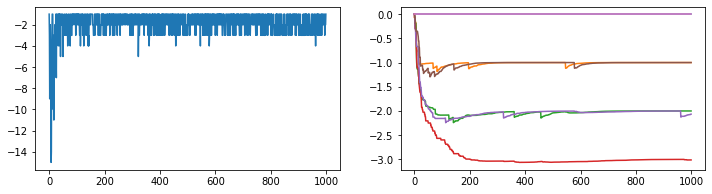

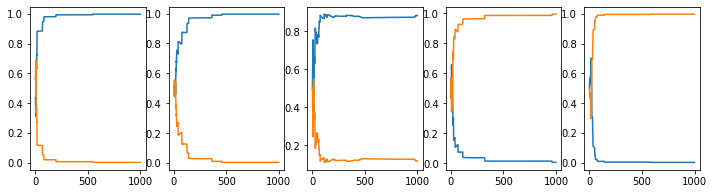

In [23]:
_, (axR, axV) = plt.subplots(ncols=2, figsize=(12,3))
axR.plot(hist_R)
axV.plot(hist_val)
plt.show()
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, figsize=(12,3))
ax1.plot(hist_prob[:,1])
ax2.plot(hist_prob[:,2])
ax3.plot(hist_prob[:,3])
ax4.plot(hist_prob[:,4])
ax5.plot(hist_prob[:,5])
plt.show()

In [60]:
env = BanditEnv()

In [61]:
hist_R, hist_val, hist_prob = one_step_actor_critic(env, ep=1000, gamma=1.0, alpha_w=2**-4, alpha_theta=2**-2)

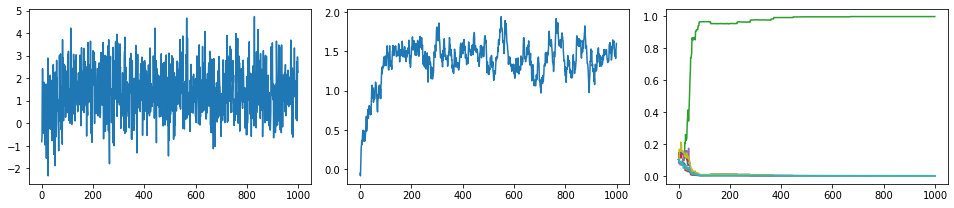

In [62]:
_, (axR, axV, axP) = plt.subplots(ncols=3, figsize=(13.4,3))
axR.plot(hist_R)
axV.plot(hist_val)
axP.plot(hist_prob[:,0])
plt.tight_layout()
plt.show()

In [80]:
env = CorridorSwitchedEnv()

In [99]:
hist_R, hist_val, hist_prob = one_step_actor_critic(env, ep=1000, gamma=1.0, alpha_w=2**-9, alpha_theta=2**-9,
                                                   init_theta=np.array([[-1.47, 1.47]]))

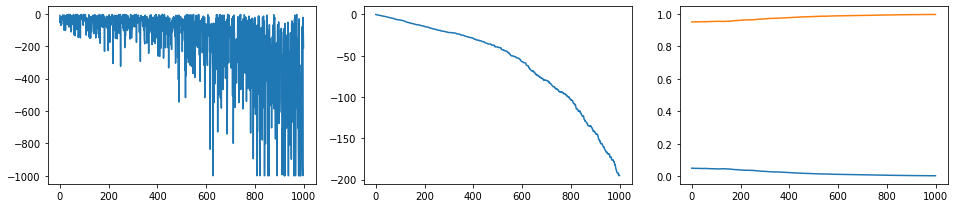

In [100]:
_, (axR, axV, axP) = plt.subplots(ncols=3, figsize=(13.4,3))
axR.plot(hist_R)
axV.plot(hist_val)
axP.plot(hist_prob[:,0])
plt.tight_layout()
plt.show()

In [105]:
class MountainCarEnv:
    """Mountain Car as described in Sutton & Barto (2018), example 10.1"""
    def __init__(self):
        self._pos = 0
        self._vel = 0
        self.state_low = np.array([-1.2, -0.07])   # min pos, min vel
        self.state_high = np.array([0.5, 0.07])    # max pos, max vel
        self.act_space = [0, 1, 2]                 # [left, idle, right]
        self.reset()

    def reset(self):
        self._pos = np.random.uniform(-0.6, -0.4)  # start pos
        self._vel = 0.0
        self._done = False
        return np.array([self._pos, self._vel], dtype=float)  # use np arrays everywhere

    def step(self, action):
        assert self._done == False
        assert action in self.act_space

        self._vel = self._vel + 0.001*(action-1) - 0.0025*np.cos(3*self._pos)
        self._vel = min(max(self._vel, -0.07), 0.07)

        self._pos = self._pos + self._vel
        self._pos = min(max(self._pos, -1.2), 0.5)

        if self._pos == -1.2:
            self._vel = 0.0

        if self._pos == 0.5:
            obs = np.array([self._pos, self._vel], dtype=float)
            reward = -1
            self._done = True
            return obs, reward, self._done
        else:
            obs = np.array([self._pos, self._vel], dtype=float)
            reward = -1
            return obs, reward, self._done

In [11]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

In [187]:
def sarsa(env, ep, gamma, alpha, eps):
    """Sarsa (on-policy TD control)
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        alpha - step size (0..1]
        eps - epsilon-greedy param
    """
    def policy(st, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[st,a] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)  # default zero for all, terminal MUST be zero
    N = defaultdict(float)
    
    for _ in range(ep):
        S = env.reset()
        A = policy(S, Q, eps)
        while True:
            S_, R, done = env.step(A)
            A_ = policy(S_, Q, eps)
            assert not done or Q[S_,A_] == 0.0
            Q[S,A] = Q[S,A] + alpha * (R + gamma * Q[S_,A_] - Q[S,A])
            N[S,A] += 1
            S, A = S_, A_
            if done: break
                
    return Q, N

In [212]:
def generate_episode(env, policy, *params):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done    = env.reset(), None, False
        else:     St, Rt, done    = env.step(At)
        At = policy(St, *params)        
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

In [208]:
def on_policy_MC_control(env, ep, gamma, eps):
    """Monte Carlo ES Control
    Params:
        env - environment
        ep [int] - number of episodes to run
        gamma [float] - discount factor
        eps [float] - epsilon-greedy parameter
    """
    
    def policy(St, Q, eps):
        if np.random.rand() > eps:
            return argmax_rand([Q[(St,a)] for a in env.act_space])
        else:
            return np.random.choice(env.act_space)
    
    Q = defaultdict(float)        # default Q value: 0
    Counts = defaultdict(int)
    Returns = defaultdict(float)  # stores SUM
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy, Q, eps)
        G = 0
        for t in range(T-1,-1,-1):
            St, _, _, At = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            G = gamma * G + Rt_1
            
            # Do away with first-visit check
            # if not (St, At) in [(traj[i][0], traj[i][3]) for i in range(0, t)]:
            Counts[(St, At)]  += 1
            Returns[(St, At)] += G
            Q[(St, At)] = Returns[(St, At)] / Counts[(St, At)]
                                    
    return Q, Counts

In [188]:
def get_V(state_Q_values, eps):
    assert isinstance(state_Q_values, list)
    assert all(isinstance(f, float) for f in state_Q_values)
    index_max = argmax_rand(state_Q_values)
    max_val = state_Q_values[index_max]
    avg_val = sum([q for q in state_Q_values]) / len(state_Q_values)
    return (1-eps)*max_val + eps*avg_val

assert get_V([0.0, 1.0, 0.0, 0.0], eps=0.1) == 0.925
assert get_V([-1.0, -1.0, 2.0, 0.0], eps=0.1) == 1.8
assert get_V([1.0, 2.0, 3.0, 4.0], eps=0.1) == 3.85

In [189]:
env = LinearEnv()
Q, N = sarsa(env, 10000, gamma=1., alpha=.5, eps=.1)

In [213]:
env = LinearEnv()
Q, N = on_policy_MC_control(env, 10000, gamma=1., eps=.1)

In [214]:
V = np.zeros(7)
N_ = np.zeros(7)
for x in range(7):
    q_0, q_1 = Q[(x,0)], Q[(x,1)]
    v = get_V([q_0, q_1], eps=0.1)
    V[x] = v
    N_[x] = N[(x,0)] + N[(x,1)]
    print(x, v)

0 0.0
1 -1.1128630705394191
2 -2.259499824841384
3 -3.221662909349787
4 -2.2187194092827007
5 -1.1123839009287926
6 0.0


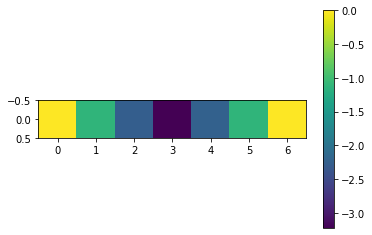

In [215]:
plt.imshow(np.expand_dims(V.T, axis=0))
plt.colorbar()

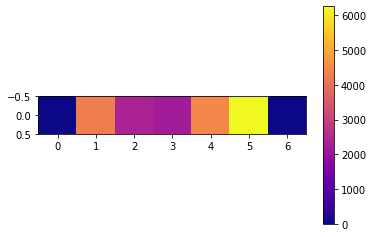

In [216]:
plt.imshow(np.expand_dims(N_.T, axis=0), cmap='plasma')
plt.colorbar()

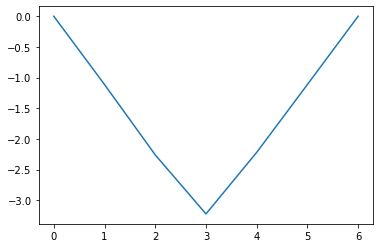

In [217]:
plt.plot(V)

In [242]:
env = WindyGridworld()
Q, N = sarsa(env, 1000, gamma=1., alpha=.5, eps=.3)

In [247]:
env = WindyGridworld()
Q, N = on_policy_MC_control(env, 10, gamma=1., eps=.3)

KeyboardInterrupt: 

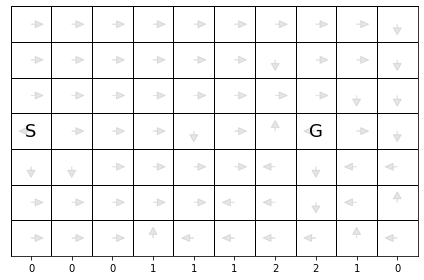

In [243]:
optimal_path = env.get_path(Q)
plot_windy(Q, optimal_path)

In [244]:
V_ = np.zeros((6, 9))
N_ = np.zeros((6, 9))
for x in range(9):
    for y in range(6):
        q_0, q_1, q_2, q_3 = Q[((x,y),0)], Q[((x,y),1)], Q[((x,y),2)], Q[((x,y),3)]
        v = get_V([q_0, q_1, q_2, q_3], eps=.1)
        V_[y, x] = v
        N_[y, x] = N[((x,y),0)] + N[((x,y),1)] + N[((x,y),2)] + N[((x,y),3)]

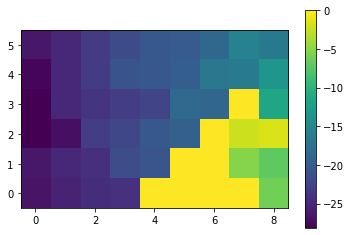

In [245]:
plt.imshow(V_, origin='lower')
plt.colorbar()

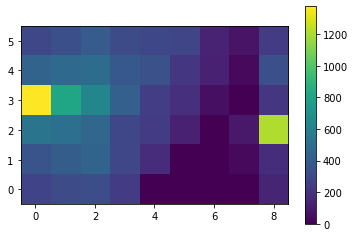

In [246]:
plt.imshow(N_, origin='lower')
plt.colorbar()